In [18]:
import numpy
import matplotlib.pyplot
import pandas
import numpy
import time
STARTTIME=time.time()
def load_and_print_fun_name(fun):
    print(time.time()-STARTTIME,fun.__name__,"函数已加载")

> 1.Author: Mao, 2021-May-28
>
> 2.空中段全重吨公里（燃油流量积分）
>
> 3.DP_PARAMS: GS, GW
>
> 4.DP_ROMS: pTKO, pLAN_OFFRWY
>
> 5.DP_HELPER_SCRIPTS: check_std_param_miss, check_kp_miss

| 变量名 | 中文解释 | 类型  |
|-----|------|-----|
| GS  | 地速   | 浮点  |
| WS  | 飞机全重 | 浮点  |

**主要业务参数**

| 助记码	        | 参数名	             | 数据类型	 | 物理单位	 | 值域上限	  | 值域下限	 | 参数用途	  | 计算逻辑描述                                                                                           |
|-------------|------------------|-------|-------|--------|-------|--------|--------------------------------------------------------------------------------------------------|
| pTKO	       | 起飞阶段起始点（加油门起飞点）	 | 整形	   | None	 | 86400	 | 0	    | 定位关键点	 | 从离地点pLIFTOFF，反向遍历，取ENG_THR_CMD_1/2 从慢车推力变为起飞推力的那1秒	                                              |
| pLAN_OFFRWY | 跑道脱离开始点          | 整形    | None  | 86400  | 0     | 定位关键点  | 从接地开始往后遍历，航向与着陆基准航向的差异达到8度的那1秒。过程中先找到差异达到20度的那1秒，再反向找到8度那1秒。对于存在U形转弯的情况，此点尚未真正开始脱离跑道，只是U形转弯的开始点。 |


In [2]:
# 检查所需标准参数是否缺失
# 输入list_param：['标准参数1', '标准参数2', ...]
def check_std_param_miss(list_param):
		list_error = []                                             # 错误列表
		str_error = "[E] Missing Param "                            # 错误码  参数缺失
		for Px in list_param:                                       # 遍历参数列表
				if not eval(Px):                                    # 检查Px计算出的值是否为0,或表达式为False
						list_error.append(Px)                       # 把错误的Px加入 错误列表(list_error)
		if len(list_error) > 0:                                     # 若有错误
				for Px in list_error:                               # 则遍历 错误列表(list_error)
						str_error += f"{Px}={eval(Px)}| "           # 拼接错误信息  错误码+具体错误
				return True, str_error[:-2]                         # 返回True(代表有错误) 和 拼接的错误信息([:-2] 去掉尾部的  '| '  两个字符串)
		else:
				return False, ''                                    #没有错误的则返回False(代表没有错误)

load_and_print_fun_name(check_std_param_miss)
# check_std_param_miss(["0","0","0"])

19.541277647018433 check_std_param_miss 函数已加载


In [4]:
# Created by Mao on 2021/Jul/30
# Last Revision by Mao on 2022/May/27
# Copyright © 2021 Reda Inc. All rights reserved.
# 检查所需关键点是否缺失
# 输入list_kp：['关键点1', '关键点2', ...]
def check_kp_miss(list_kp):

    list_error = []
    str_error = "[E] Missing Key Point "

	# 先遍历要检测的关键点，将存在错误的写入 list_error
    for Px in list_kp:
        if not eval(Px):
            list_error.append(Px)
        elif eval(Px).time is None:
            list_error.append(Px)

	# 将 list_error 中的参数的错误信息放到一起
    if len(list_error) > 0:
        for Px in list_error:
            str_error += f"[{Px}: "
            if hasattr(eval(Px), 'error'):
                str_error += f"{eval(Px).error}]| "
            else:
                str_error += f"Not calced.]| "
        return True, str_error[:-2]
    else:
        return False, ''

# 修订记录
# 2022-May-27 增加对依赖参数没有计算情况的报错
load_and_print_fun_name(check_kp_miss)

173.40715146064758 check_kp_miss 函数已加载


In [45]:

def rTRIP_GWTK_FCF_AIR_rom(info, result):
# 检查所需标准参数是否存在
    LIST_PARAM = ['GS','GW']
    flg_err, str_err = check_std_param_miss(LIST_PARAM)         #使用check_std_param_miss判断  地速GS  和  飞机全重GW  是否存在
    if flg_err == True:                                         #若不存在则返回异常信息
        result.error = str_err
        return result

    # 检查所需关键点是否存在
    LIST_KP = ['pTKO', 'pLAN_OFFRWY']
    flg_err, str_err = check_kp_miss(LIST_KP)
    if flg_err == True:
        result.error = str_err
        return result

    # 以下为主体逻辑
    np = numpy                                                          #numpy 别名 np
    time_start = pTKO.time                                              #开始时间   起飞阶段起始点（加油门起飞点）的时间
    time_end = pLAN_OFFRWY.time                                         #结束时间   跑道脱离开始点的时间
    arr_GS = np.array(GS[time_start : time_end + 1])                    #区间地速数组
    arr_GW = np.array(GW[time_start : time_end + 1])                    #区间飞机全重数组
                                                                    #使用梯形求积公式求出近似  地速和飞机全重的积
    arr_GS_AVG = (arr_GS[:-1] + arr_GS[1:]) / 2                         #arr_GS_AVG 每两帧地速的平均值 数组
    arr_GW_AVG = (arr_GW[:-1] + arr_GW[1:]) / 2                         #arr_GW_AVG 每两帧飞机全重的平均值 数组

    arr_GWTK = arr_GW_AVG / 1000 * arr_GS_AVG * 1.852 / 3600            #飞机全重吨公里   飞机全重*地速   计算方法: 飞机全重/1000(千克转换为吨)*地速*1.852/3600(节转换为公里)   时间小时换算为秒

    result.value = sum(arr_GWTK)                                        #求积
    result.time = pLAN_OFFRWY.time                                      #返回时间    跑道脱离开始点的时间
    return result

In [34]:
df=pandas.read_csv('cvs/GS GW.csv')

In [15]:
arr_GS = numpy.array(df.GS)
arr_GW =numpy.array(df.GW)
arr_GS_AVG = (arr_GS[:-1] + arr_GS[1:]) / 2
arr_GW_AVG = (arr_GW[:-1] + arr_GW[1:]) / 2
arr_GWTK = arr_GW_AVG / 1000 * arr_GS_AVG * 1.852 / 3600
sum(arr_GWTK)

173.7996668499932


```python
   arr_GS_AVG = (arr_GS[:-1] + arr_GS[1:]) / 2
```

$
\sum_{i=time\_start}^{time\_end-1}(GS_i+GS_{i+1})/2
$

```python
   arr_GW_AVG = (arr_GW[:-1] + arr_GW[1:]) / 2
```

$
\sum_{i=time\_start}^{time\_end-1}(GW_i+GW_{i+1})/2
$





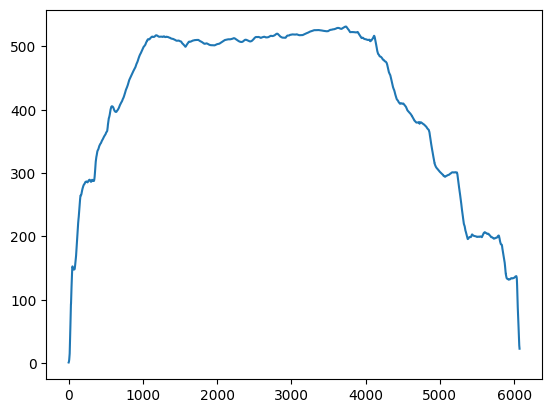

In [20]:
x=range(0,df.index.size)
matplotlib.pyplot.plot(x,arr_GS)
matplotlib.pyplot.show()

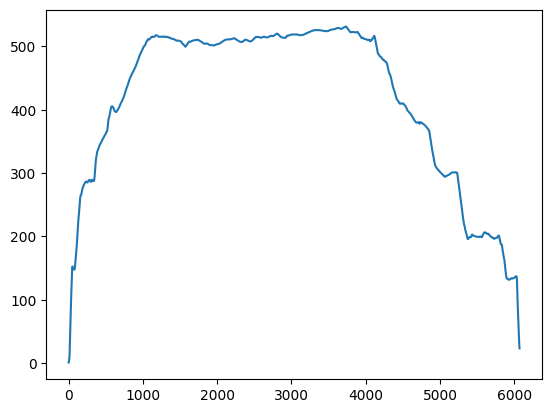

In [23]:
matplotlib.pyplot.plot(x[:-1],arr_GS_AVG)
matplotlib.pyplot.show()

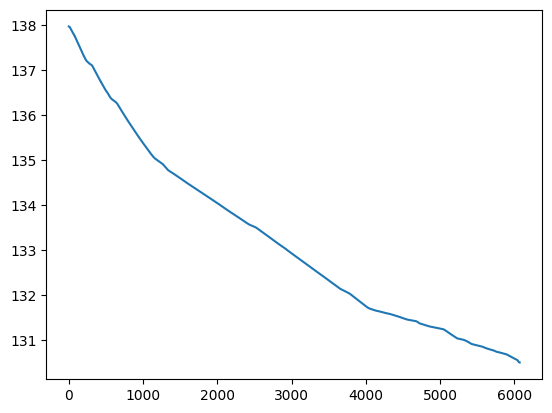

In [24]:
matplotlib.pyplot.plot(x,arr_GW)
matplotlib.pyplot.show()

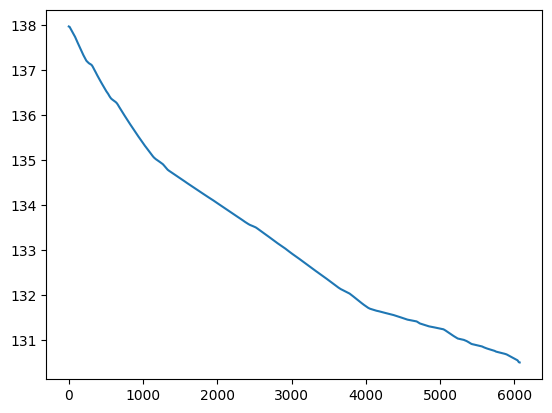

In [25]:
matplotlib.pyplot.plot(x[:-1],arr_GW_AVG)
matplotlib.pyplot.show()

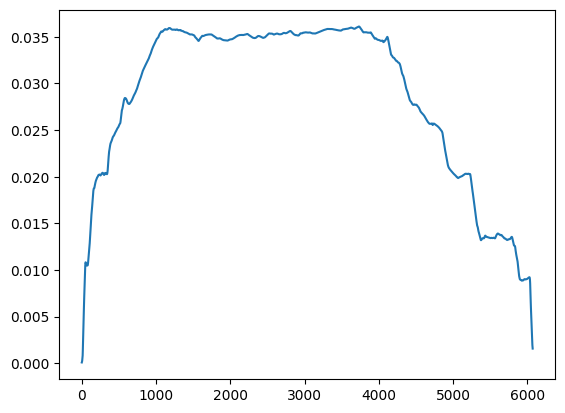

In [28]:
matplotlib.pyplot.plot(x[:-1],arr_GWTK)
matplotlib.pyplot.show()


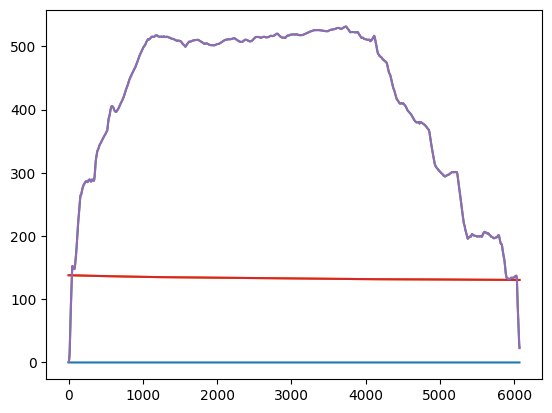

In [31]:
matplotlib.pyplot.plot(x[:-1],arr_GWTK)
matplotlib.pyplot.plot(x[:-1],arr_GW_AVG)
matplotlib.pyplot.plot(x[:-1],arr_GS_AVG)
matplotlib.pyplot.plot(x,arr_GW)
matplotlib.pyplot.plot(x,arr_GS)
matplotlib.pyplot.show()

In [33]:
df1=pandas.read_csv("cvs/FF.csv")

In [36]:
def get_integral_cal(arr_x, arr_y, coff):
    # 首先检查x和y序列长度是否一致
    if len(arr_x) != len(arr_y):
        return False

    # 以下为正式计算
    np = numpy
    rx = np.array(arr_x)
    ry = np.array(arr_y)

    val_sum = np.sum((rx[1:] - rx[:-1]) * ((ry[:-1] + ry[1:]) / 2)) * coff

    return val_sum

In [38]:
df = pandas.read_csv("cvs/FF.csv")
FUEL_FLOW_1 = df.FF1
FUEL_FLOW_2 = df.FF2

# 计算油量
LIST_FC = []
LIST_FF = [FUEL_FLOW_1, FUEL_FLOW_2]
for Px in LIST_FF:
    arr_FF = Px
    LIST_FC.append(get_integral_cal(range(0, df.index.size), arr_FF, 1 / 3600))

print(round(sum(LIST_FC), 6))

16575.098376
